# SPISEA: Making a Cluster with BD Candidates

This is a document to generate a synthetic cluster in SPISEA with the addition of brown dwarf candidates. It will follow the Quick Start Guide closely, but with changes due to a lower mass limit and ability to consider smaller objects.

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

### 1: Making an Isochrone Object for our Cluster

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Specify the directory we want the output isochrone
# table saved in. If the directory does not already exist,
# SPISEA will create it.
iso_dir = 'isochrones/'

# Make IsochronePhot object. Note that this will take a minute or two, 
# unless the isochrone has been generated previously.
#
# Note that this is not show all of the user options 
# for IsochronePhot. See docs for complete list of options.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)

Changing to logg=4.00 for T= 32651 logg=3.99
Changing to logg=4.00 for T= 32840 logg=3.98
Changing to logg=4.00 for T= 33037 logg=3.97
Changing to logg=4.00 for T= 33144 logg=3.96
Changing to logg=4.00 for T= 33205 logg=3.95
Changing to logg=4.00 for T= 33358 logg=3.94
Changing to logg=4.00 for T= 33504 logg=3.93
Changing to logg=4.00 for T= 33651 logg=3.91
Changing to logg=4.00 for T= 33713 logg=3.91
Changing to logg=4.00 for T= 33775 logg=3.90
Changing to logg=4.00 for T= 33892 logg=3.89
Changing to logg=4.00 for T= 34002 logg=3.87
Changing to logg=4.00 for T= 34111 logg=3.86
Changing to logg=4.00 for T= 34182 logg=3.85
Changing to logg=4.00 for T= 34222 logg=3.85
Changing to logg=4.00 for T= 34332 logg=3.83
Changing to logg=4.00 for T= 34443 logg=3.82
Changing to logg=4.00 for T= 34546 logg=3.81
Changing to logg=4.00 for T= 34658 logg=3.80
Changing to logg=4.00 for T= 34674 logg=3.80
Changing to logg=4.00 for T= 34746 logg=3.79
Changing to logg=4.00 for T= 34842 logg=3.78
Changing t

In [3]:
# The stars in the isochrone and associated properties  
# are stored in an astropy table called "points" 
# within the IsochronePhot object. 
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
 6.591312905046435e+24  2928.195035574271 ... 21.454394826602254
  7.13135291244921e+24 2943.7437337117412 ...   21.3665241093368
 7.761969450327467e+24 2958.6936525140045 ... 21.272757288262653
 8.296060854703104e+24  2975.089258880875 ...  21.19905370697203
 8.830228238420424e+24  2992.264636608189 ...  21.13035092375595
 8.860779496066351e+24  3009.539168873201 ...  21.12685391099373
                   ...                ... ...                ...
2.1036424651269878e+32  63037.64788294872 ...  11.22232056398674
2.1760653272980036e+32   64239.1816824387 ... 11.267570563986745
 2.250981517613893e+32  65463.61740672747 ... 11.312820563986737
2.3279407848949313e+32  66696.03248243559 ... 11.357320563986734
2.4080856466771184e+32  67967.29719504561 ...  11.40257056398674
2.4909896846856737e+32  6

In [4]:
# Example case:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.051 mag, F139M = 18.453 mag, F153M = 17.785 mag


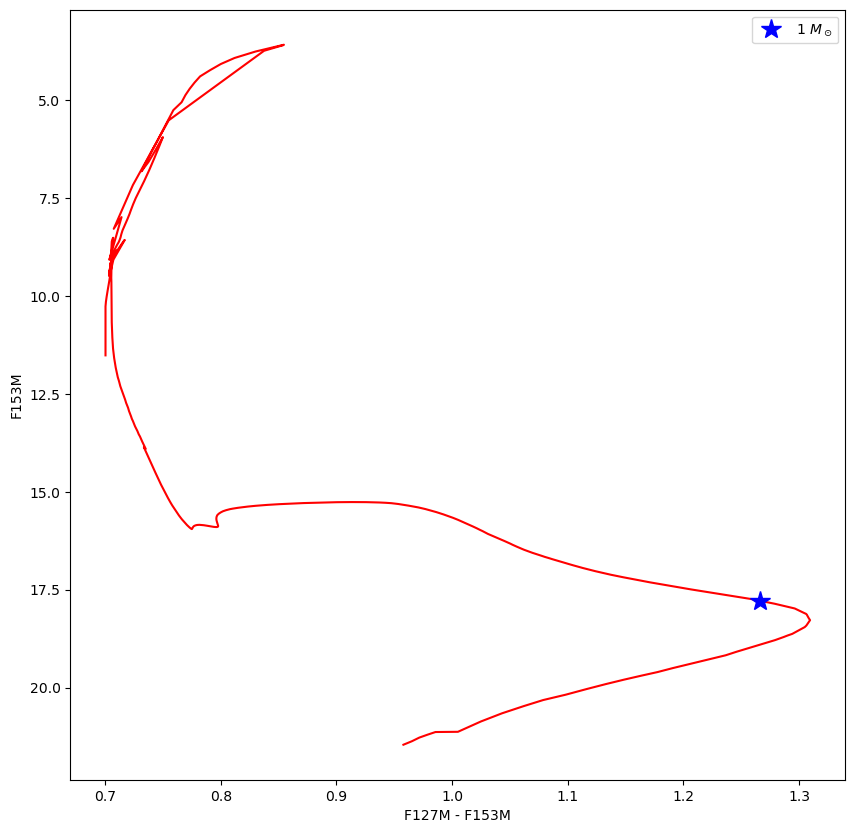

In [5]:
# Make a color-magnitude diagram from the isochrone
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### 2: Bringing in an IMF

In [25]:
# Make multiplicity object Here, we use the MultiplicityUnresolved object, 
# based on Lu+13. This means that star systems will be unresolved, i.e., 
# that all components of a star system are combined into a single "star" in the cluster
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

my_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)

### 3: Generating Cluster

In [26]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

Found 60499 stars out of mass range
Found 11203 companions out of stellar mass range


In [27]:
# Look at star systems table
print(cluster.star_systems)

        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
0.31585425987928323       True ...  18.92999676208373            2
0.11445929647600789      False ... 20.934530625744358            0
  0.645145955409843      False ...  18.42659654946194            0
 0.2125430430785249      False ...  20.08717879087111            0
 0.4443648340365779      False ... 18.982532572754547            0
 0.9427790018124477       True ...   17.5522451444909            1
0.20316227789117086      False ... 20.155331870086147            0
                ...        ... ...                ...          ...
0.07822412513422393      False ... 21.306060916420513            0
0.17640075706320751      False ... 20.342815617558465            0
0.09652737394053626      False ... 21.126211979448616            0
 0.1622394758046402      False ...  20.45232101696704            0
0.39015806512343487      False ...   19.2083064020004         

In [28]:
# The companions table is accessed in a similar way
print(cluster.companions)

system_idx         mass        ...    m_hst_f139m        m_hst_f153m    
---------- ------------------- ... ------------------ ------------------
         0  0.0460428924123163 ...                nan                nan
         0 0.24553283737800713 ... 20.536185197536078  19.87454892207238
         5  0.4308071906008011 ... 19.720217136851623 19.036277872397545
         8 0.05926443486987895 ...                nan                nan
        10 0.37939808636570665 ... 19.922230480262495 19.247518348082274
        15 0.12172477389722892 ...  21.49272357482301  20.84357767155626
        16  0.4299286896336996 ...  19.72390856044099 19.040131407955787
       ...                 ... ...                ...                ...
    122997 0.24062971315528156 ...  20.56327953828116  19.90217696791337
    122998 0.44959030611032147 ... 19.653329536810013  18.96646512002086
    123000  0.3746449017452262 ...  19.94002433187758 19.265866413907457
    123000  0.3396256601362069 ... 20.0783976822023

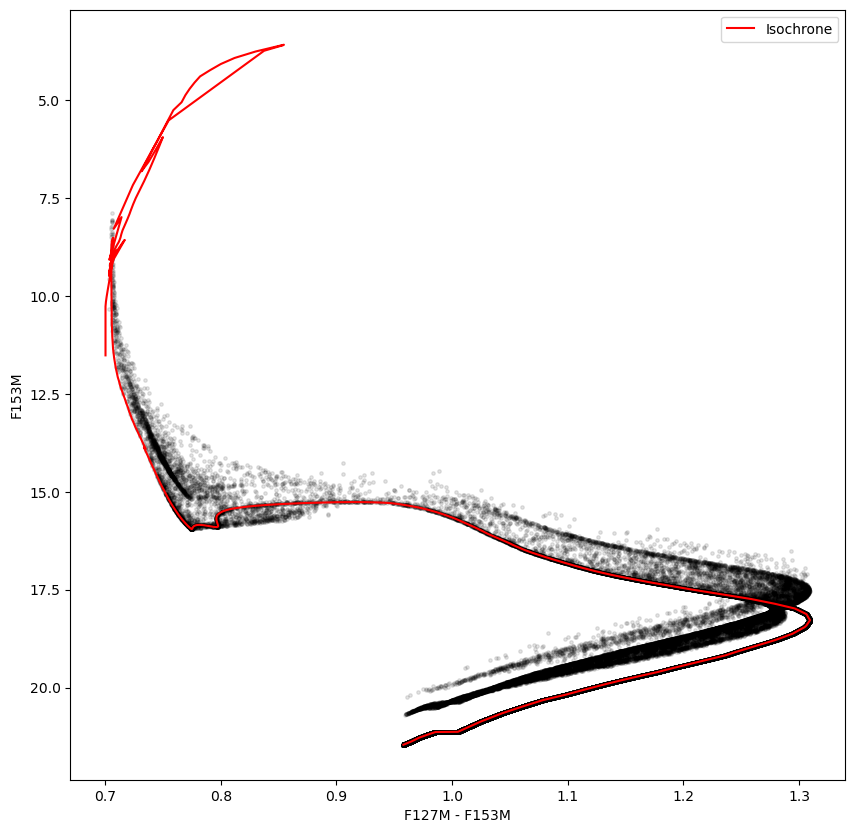

In [29]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

In [35]:
print("minimum primary mass: " + str(np.min(clust['mass'])))
print("minimum companion mass: " + str(np.min(cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(clust['mass'])))
print("maximum companion mass: " + str(np.max(cluster.companions['mass'])))

minimum primary mass: 0.07000163959328269
minimum companion mass: 0.01000292189962548
maximum primary mass: 55.80384055631119
maximum companion mass: 44.92501458090958


#### Creating a histogram to compare Weidner Kroupa and Muzic

In [36]:
#generate clusters for each class
w_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)
m_imf = imf.Muzic_2017(multiplicity=imf_multi)

In [37]:
# Define total cluster mass
mass = 10**5.

# Make cluster objects for each
w_cluster = synthetic.ResolvedCluster(my_iso, w_imf, mass)
m_cluster = synthetic.ResolvedCluster(my_iso, m_imf, mass)

Found 58485 stars out of mass range
Found 10731 companions out of stellar mass range
Found 256 stars out of mass range
Found 83 companions out of stellar mass range


In [40]:
#show total numbers for each cluster
print("primary masses in Weidner Kroupa cluster: " + str(len(w_cluster.star_systems)))
print("companion masses in Weidner Kroupa cluster: " + str(len(w_cluster.companions)))
print("primary masses in Muzic cluster: " + str(len(m_cluster.star_systems)))
print("companion masses in Muzic cluster: " + str(len(m_cluster.companions)))

primary masses in Weidner Kroupa cluster: 119280
companion masses in Weidner Kroupa cluster: 32991
primary masses in Muzic cluster: 1113
companion masses in Muzic cluster: 682


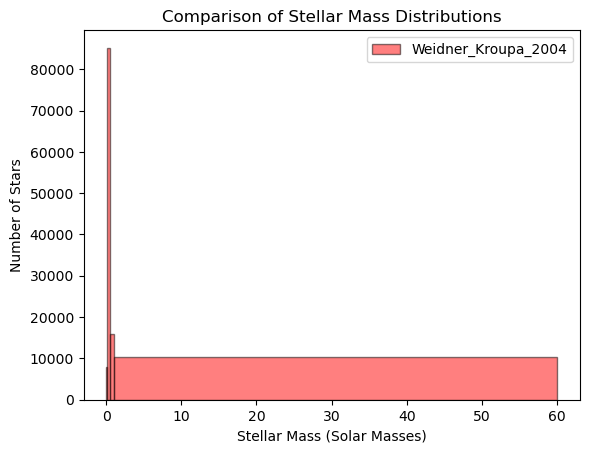

In [44]:
#define masses
w_masses = w_cluster.star_systems['mass']
w_comps = w_cluster.companions['mass']
m_masses = m_cluster.star_systems['mass']
m_comps = m_cluster.companions['mass']

#define mass range of histogram
mass_ranges = [0.01, 0.08, 0.5, 1, 60]

#create a histogram to compare
#plt.hist(m_masses, bins=mass_ranges, alpha=0.5, label='Muzic_2017', color='blue', edgecolor='black')
plt.hist(w_masses, bins=mass_ranges, alpha=0.5, label='Weidner_Kroupa_2004', color='red', edgecolor='black')

#labels and legend
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Number of Stars')
plt.title('Comparison of Stellar Mass Distributions')
plt.legend()
plt.show()